# **NOTE!**
> this notebook needs to be ran *AFTER* create_nodule_df.csv has been executed so that the nodule_df.csv file is in the preprocessing folder.

A holdout set is created from the nodule_df.csv file (which in turns is computed from the create_nodule_df.py script as just described). That is, the nodule_df.csv contains *ALL* nodules (train/validation + holdout). It is in this notebook that the nodule_df.csv file is subsetted into the hold_out_nodule_df.csv and the processed_nodule_df.csv. 

Furthermore, the processed_nodule_df.csv is a filtered version of the remaining nodules after extracting the holdout nodules into a seperate set.

In [ ]:
rom project_config import SEED, env_config
from utils.common_imports import *
import matplotlib.pyplot as plt

from utils.logger_setup import logger

nodule_df = pd.read_csv(f"{env_config.nodule_df_file}")

PROCESSED_NODULE_DF_NAME = "processed_nodule_df"
display(nodule_df.shape)
nodule_df.columns

(2625, 52)

Index(['nodule_id', 'scan_id', 'nodule_idx', 'scan_slice_thickness',
       'scan_slice_spacing', 'scan_pixel_spacing', 'scan_contrast_used',
       'malignancy_scores', 'subtlety_scores', 'ann_internalStructure_scores',
       'ann_calcification_scores', 'ann_sphericity_scores',
       'ann_margin_scores', 'ann_lobulation_scores', 'ann_spiculation_scores',
       'ann_texture_scores', 'nodule_annotation_ids',
       'nodule_annotation_count', 'ann_mean_diameter', 'ann_mean_volume',
       'consensus_centroid', 'scaling_factors', 'consensus_bbox_10',
       'consensus_bbox_20', 'consensus_bbox_30', 'consensus_bbox_40',
       'consensus_bbox_50', 'consensus_bbox_60', 'consensus_bbox_70',
       'consensus_bbox_80', 'consensus_bbox_90', 'consensus_bbox_100',
       'malignancy_consensus', 'cancer_label', 'subtlety_consensus',
       'internalStructure_consensus', 'calcification_consensus',
       'sphericity_consensus', 'margin_consensus', 'lobulation_consensus',
       'spiculation_con

# Inspect how many nodule ROI bboxes that exceed the scan border
this is done to decide which `max_image_dim` to use.

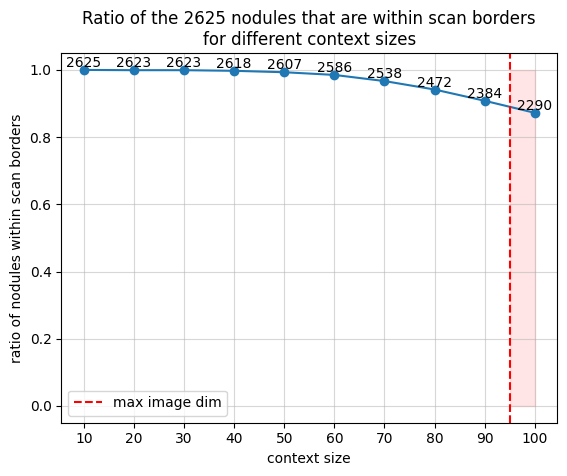

In [3]:
ratios = {}
numbers = {}
max_image_dim = 90
for context_size in [10,20,30,40,50,60,70,80,90,100]:
    filtered = nodule_df.query(f"bbox_{context_size}_standardised == True")
    ratios[context_size] = len(filtered) / len(nodule_df)
    numbers[context_size] = len(filtered)

# plot ratios
plt.plot(ratios.keys(), ratios.values(), marker='o')
# add barplot of the number of nodules that exceeds the scan borders
for context_size, ratio in ratios.items():
    plt.text(context_size, ratio, f"{numbers[context_size]}", ha='center', va='bottom')
plt.xlabel("context size")
plt.xticks(list(ratios.keys()))
plt.ylabel("ratio of nodules within scan borders")
plt.axvline(x=max_image_dim + 5, color='r', linestyle='--', label="max image dim")
plt.fill_betweenx(y=[0,1], x1=max_image_dim+5, x2=100, color='r', alpha=0.1)
plt.title(f"Ratio of the {len(nodule_df)} nodules that are within scan borders\nfor different context sizes")
plt.grid(alpha=0.5)
plt.legend(loc="lower left")
plt.show()

# Necesarry Filtering
1) filter out nodules whos bbox exceeds the scan edge at bbox size 70

In [5]:
max_image_dim = 90
filtered_nodule_df = nodule_df.query(f"bbox_{max_image_dim}_standardised == True")
logger.info(f"\nremoving {nodule_df.shape[0] - filtered_nodule_df.shape[0]} nodules that are not within scan.\nMax image dim used: {max_image_dim}")

print("\nnodule_df shape:", filtered_nodule_df.shape)

[INFO|1298383292.py|<module>|L3] 2024-11-24 11:20:26: 
removing 241 nodules that are not within scan.
Max image dim used: 90

nodule_df shape: (2384, 52)


# Create hold out set
The holdout set is created from the nodule_df.csv file (which in turns is computed from the create_nodule_df.py script). That is, the nodule_df.csv contains *ALL* nodules (train/validation + holdout). It is in this notebook that the nodule_df.csv file is subsetted into the hold_out_nodule_df.csv and the processed_nodule_df.csv.

In [6]:
from sklearn.model_selection import StratifiedGroupKFold

FOLDS = 10  # use ~10 percent of the data for the hold out set

sgkf = StratifiedGroupKFold(n_splits=FOLDS, shuffle=True, random_state=SEED)
for fold, (train_idxs, test_idxs) in enumerate(
    sgkf.split(
        X=filtered_nodule_df, y=filtered_nodule_df["malignancy_consensus"], groups=filtered_nodule_df["scan_id"]
    )
):
    hold_out_rows = filtered_nodule_df.iloc[test_idxs]["scan_id"]
    hold_out_pids = hold_out_rows.unique().tolist()
    logger.info(
        f"Using {len(hold_out_rows)} hold out instances (nodules)"
    )
    break

[INFO|1452878684.py|<module>|L13] 2024-11-24 11:20:55: Using 271 hold out instances (nodules)


In [7]:
# create hold out df:
hold_out_df = filtered_nodule_df[filtered_nodule_df["scan_id"].isin(hold_out_pids)].reset_index(drop=True)
hold_out_df.to_csv(f"{env_config.hold_out_nodule_df_file}", index=False)
print(f"hold_out_df: {hold_out_df.shape}")

# remove hold out pids from nodule_df:
filtered_nodule_df = filtered_nodule_df[~filtered_nodule_df["scan_id"].isin(hold_out_pids)].reset_index(drop=True)
print(f"filtered_nodule_df: {filtered_nodule_df.shape}")

hold_out_df: (271, 52)
filtered_nodule_df: (2113, 52)


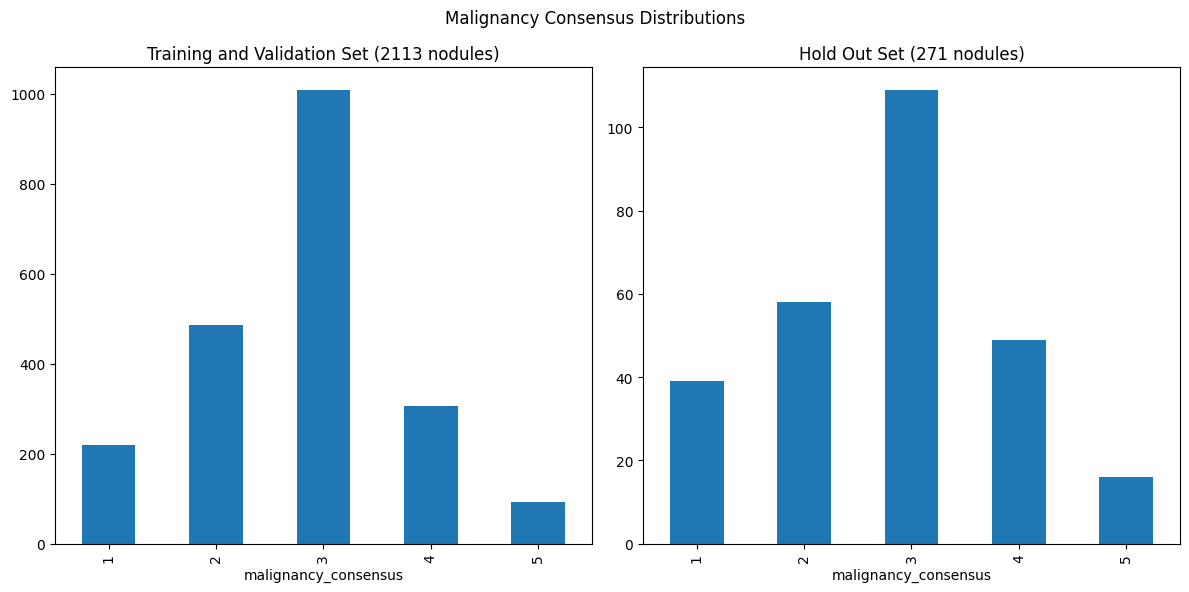

In [9]:
# investigate malignancy distribution between hold out and filtered_nodule_df:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

filtered_nodule_df["malignancy_consensus"].value_counts().sort_index().plot(kind="bar", ax=ax[0])
ax[0].set_title(f"Training and Validation Set ({len(filtered_nodule_df)} nodules)")

hold_out_df["malignancy_consensus"].value_counts().sort_index().plot(kind="bar", ax=ax[1])
ax[1].set_title(f"Hold Out Set ({len(hold_out_df)} nodules)")

plt.suptitle("Malignancy Consensus Distributions")
plt.tight_layout()
plt.show()

# Write out processed nodule df to file

In [12]:
# verify that the new nodule_df is the same as the old one (despite adding more attributes):

df_old = pd.read_csv("preprocessing/files_from_before_adding_nodule_ids/nodule_df_OLD.csv").drop(columns=["index", "pid"])
df_new = pd.read_csv("preprocessing/nodule_df.csv")
display(df_new[df_old.columns].equals(df_old))

df_processed_old = pd.read_csv("preprocessing/files_from_before_adding_nodule_ids/processed_nodule_df_OLD.csv").drop(columns=["index", "pid"])
df_processed_new = pd.read_csv("preprocessing/processed_nodule_df.csv")
display(df_processed_new[df_old.columns].equals(df_processed_old))

df_hold_out_old = pd.read_csv("preprocessing/files_from_before_adding_nodule_ids/hold_out_nodule_df_OLD.csv").drop(columns=["index", "pid"])
df_hold_out_new = pd.read_csv("preprocessing/hold_out_nodule_df.csv")
display(df_hold_out_new[df_hold_out_old.columns].equals(df_hold_out_old))


True

True

True

In [13]:
try:
    filtered_nodule_df.to_csv(f"{env_config.PROJECT_DIR}/preprocessing/{PROCESSED_NODULE_DF_NAME}.csv", index=False)
except Exception as e:
    logger.error(f"Error saving nodule_df dataframe: {e}")